<a href="https://colab.research.google.com/github/timothy2077/1st-Rep/blob/master/Main_Quest_3_Pneumonia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 폐렴아 기다려라! (노드 학습)

1)  2-4. 폐렴을 진단해보자 (1)

2)  2-5. 폐렴을 진단해보자 (2)

## 0. 구글 드라이브 마운트

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


## 1. Set-up

A. PKG Import

In [ ]:
import os, re
import random, math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings(action='ignore')

B. 필요한 변수 설정

In [ ]:
# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE
# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [180, 180]

# 데이터 경로 변수
ROOT_PATH = "/content/drive/MyDrive/1NOQy_THOFkRRlFyuT7aoipg1I5FLlSph"
TRAIN_PATH = ROOT_PATH + '/chest_xray/data/train/*/*' # *은 모든 디렉토리와 파일을 의미합니다.
VAL_PATH = ROOT_PATH + '/chest_xray/data/val/*/*'
TEST_PATH = ROOT_PATH + '/chest_xray/data/test/*/*'

# 프로젝트를 진행할 때 아래 두 변수를 변경해보세요
BATCH_SIZE = 16
EPOCHS = 10

print(ROOT_PATH)


/content/drive/MyDrive/1NOQy_THOFkRRlFyuT7aoipg1I5FLlSph


c. **"거의 바꿔볼 수 있을 게 없을 것 같지만, Batch size, Epoch 등을 변경해볼 수 있을 것입니다"**

In [ ]:
# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE
# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [180, 180]

# 데이터 경로 변수
ROOT_PATH = "/content/drive/MyDrive/1NOQy_THOFkRRlFyuT7aoipg1I5FLlSph"
TRAIN_PATH = ROOT_PATH + '/chest_xray/data/train/*/*' # *은 모든 디렉토리와 파일을 의미합니다.
VAL_PATH = ROOT_PATH + '/chest_xray/data/val/*/*'
TEST_PATH = ROOT_PATH + '/chest_xray/data/test/*/*'

# 프로젝트를 진행할 때 아래 두 변수를 변경해보세요
BATCH_SIZE = 32  # 변경된 부분
EPOCHS = 20  # 변경된 부분

print(ROOT_PATH)


/content/drive/MyDrive/1NOQy_THOFkRRlFyuT7aoipg1I5FLlSph


## 2. 데이터 가져오기

In [ ]:
import os
import glob
import tensorflow as tf

# Google 드라이브 마운트
from google.colab import drive
drive.mount('/content/drive')

# 데이터 경로 설정
ROOT_PATH = '/content/drive/My Drive/chest_xray'
TRAIN_PATH = os.path.join(ROOT_PATH, 'train', '*', '*')
VAL_PATH = os.path.join(ROOT_PATH, 'val', '*', '*')
TEST_PATH = os.path.join(ROOT_PATH, 'test', '*', '*')

# 데이터셋 파일 경로 리스트 만들기
train_list_ds = tf.data.Dataset.list_files(TRAIN_PATH)
val_list_ds = tf.data.Dataset.list_files(VAL_PATH)
test_list_ds = tf.data.Dataset.list_files(TEST_PATH)

# 데이터셋 개수 확인
print("Training images count:", len(glob.glob(TRAIN_PATH)))
print("Validation images count:", len(glob.glob(VAL_PATH)))
print("Test images count:", len(glob.glob(TEST_PATH)))


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Training images count: 5235
Validation images count: 16
Test images count: 633


A. test’, ‘train’, ‘val’ 폴더 각각의 ‘NORMAL’ 및 ‘PNEUMONIA’ 서브폴더의 이미지 파일(파일 이름이 이미지 확장자로 끝나는 것들만)을 나열해보기

In [ ]:
import os

def list_images(directory):
    for root, dirs, files in os.walk(directory):
        path = root.split(os.sep)
        print((len(path) - 1) * '---', os.path.basename(root))
        for file in files:
            if file.lower().endswith(('.png', '.jpg', '.jpeg', '.tiff', '.bmp', '.gif')):
                print(len(path) * '---', file)

list_images('/content/drive/My Drive/chest_xray')


B. 오직 16개의 val 데이터 수 때문에 train에서 val에 쓰일 데이터 더 가져오기 (train : val를 80:20으로 분할하기)

In [ ]:
# train 데이터와 validation 데이터를 모두 filenames에 담습니다
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

# 모아진 filenames를 8:2로 나눕니다
train_size = math.floor(len(filenames)*0.8)
random.seed(8)
random.shuffle(filenames)
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

print(len(train_filenames))
print(len(val_filenames))

4200
1051


C. 정상 이미지와 폐렴 이미지를 구분

In [ ]:
print(f'Normal image path\n{filenames[0]}')
print(f'Pneumonia image path\n{filenames[2000]}')

Normal image path
/content/drive/My Drive/chest_xray/train/PNEUMONIA/person374_bacteria_1711.jpeg
Pneumonia image path
/content/drive/My Drive/chest_xray/train/NORMAL/NORMAL2-IM-1345-0001-0002.jpeg


D. 정상 이미지 개수와 폐렴 이미지 개수 확인하기

In [ ]:
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print(f"Normal images count in training set: {COUNT_NORMAL}")


COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print(f"Pneumonia images count in training set: {COUNT_PNEUMONIA}")

Normal images count in training set: 1087
Pneumonia images count in training set: 3113


(질문) Batch Size 는 왜 생겼을까?

- 데이터가 엄청나게 많은 경우 전체 데이터를 보고 최적화를 할 때 엄청난 시간이 할애될 수 있다.

- 따라서, 정확도는 좀 떨어지지만 Batch Size를 줄여서 시간을 단축시키는 것이다.

In [ ]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

E. Train 데이터셋, validation 데이터셋 개수 확인하기

In [ ]:
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print(f"Training images count: {TRAIN_IMG_COUNT}")

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print(f"Validating images count: {VAL_IMG_COUNT}")

Training images count: 4200
Validating images count: 1051


F.  라벨 데이터를 만들어 주는 함수 만들기

In [ ]:
# 파일 경로의 끝에서 두번째 부분을 확인하면 양성과 음성을 구분할 수 있습니다
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"   # 폐렴이면 양성(True), 노말이면 음성(False)

G. 이미지의 사이즈를 통일 시키고 GPU 메모리를 더욱 효율적으로 사용하기 위해 이미지 사이즈를 줄이기

(decode_img 함수와 process_path 함수를 만들기)

In [ ]:
# 이미지를 알맞은 형식으로 바꿉니다.
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3) # 이미지를 uint8 tensor로 수정
    img = tf.image.convert_image_dtype(img, tf.float32) # float32 타입으로 수정
    img = tf.image.resize(img, IMAGE_SIZE) # 이미지 사이즈를 IMAGE_SIZE로 수정
    return img

# 이미지 파일의 경로를 입력하면 이미지와 라벨을 읽어옵니다.
def process_path(file_path):
    label = get_label(file_path) # 라벨 검출
    img = tf.io.read_file(file_path) # 이미지 읽기
    img = decode_img(img) # 이미지를 알맞은 형식으로 수정
    return img, label

H. train 데이터 셋과 validation 데이터 셋을 만들기

(num_parallel_calls 파라미터에 위에서 할당한 AUTOTUNE변수를 이용하기)


In [ ]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

I. 이미지가 잘 리사이즈 되었고 라벨이 잘 들어가 있는지 확인하기

In [ ]:
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  True


J. test 데이터셋도 만들기와 test 데이터 개수 확인하기

In [ ]:
test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

633


K. tf.data 파이프라인을 이용하여 prepare_for_training() 함수 만들기

shuffle()을 사용하기

repeat()를 사용하기

batch()를 사용하기

prefetch()를 사용하기

In [ ]:
def prepare_for_training(ds, shuffle_buffer_size=1000):
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

## 3. 데이터 시각화

train에 있는 batch 중 첫 번째 배치를 추출하여 image와 label 데이터 셋으로 나눈 후에 show_batch() 함수를 이용해서 결과 사진 확인하기

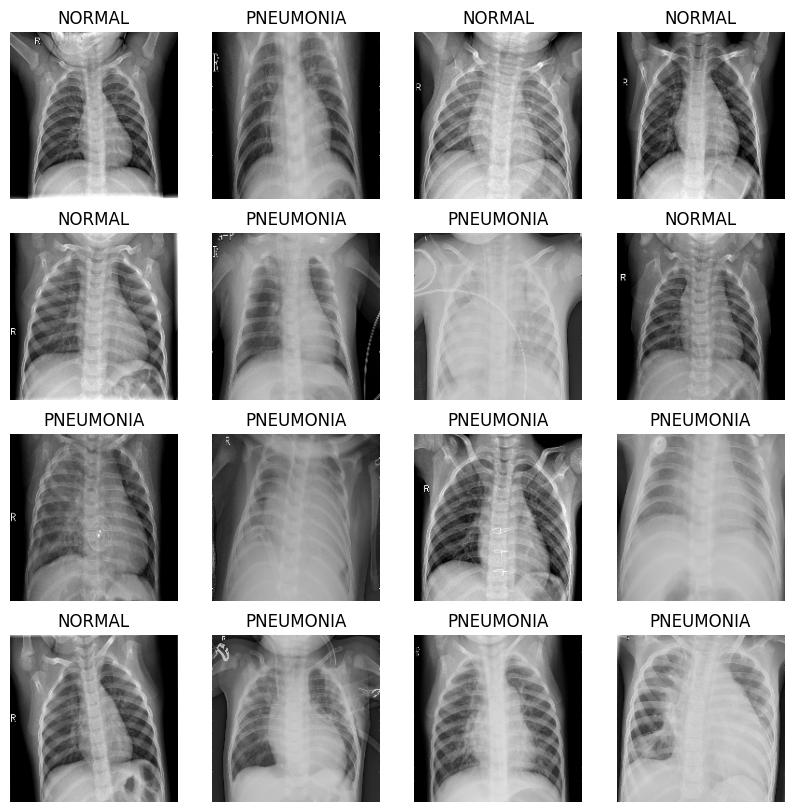

In [ ]:
# 이미지 배치를 입력하면 여러장의 이미지를 보여줍니다.
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(4,math.ceil(BATCH_SIZE/4),n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")


image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch.numpy(), label_batch.numpy())

## 4. CNN 모델링

A. Convolution Block 만들기

In [ ]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])

    return block

B. Dense Block 만들기

In [ ]:
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])

    return block

C. Batch Normalization과 Dropout이라는 두 가지 Regularization 기법 함께 사용하기


In [ ]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),

        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),

        conv_block(32),
        conv_block(64),

        conv_block(128),
        tf.keras.layers.Dropout(0.2),

        conv_block(256),
        tf.keras.layers.Dropout(0.2),

        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),

        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    return model

## 5. 데이터 imbalance 처리

Weight balancing을 통해 training set의 각 데이터에서 loss를 계산할 때 특정 클래스의 데이터에 더 큰 loss 값을 갖도록 가중치를 부여하기

In [ ]:
import os

# 'root_dir'는 검색을 시작할 최상위 디렉토리입니다.
root_dir = '/content/drive/MyDrive/1NOQy_THOFkRRlFyuT7aoipg1I5FLlSph'

# 'normal_images_dir'는 찾고자 하는 디렉토리의 이름입니다.
normal_images_dir = 'normal_images'

for dirpath, dirnames, filenames in os.walk(root_dir):
    if normal_images_dir in dirnames:
        path_to_normal_images = os.path.join(dirpath, normal_images_dir)
        print(f"'{normal_images_dir}' 디렉토리의 경로: {path_to_normal_images}")


In [ ]:
COUNT_NORMAL = 100
COUNT_PNEUMONIA = 150
TRAIN_IMG_COUNT = 250

weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.25
Weight for PNEUMONIA: 0.83


## 6. 모델 훈련


A. build_model()을 Model에 선언하고 "binary_cross entropy" Loss를 사용하며 Optimizer로 'adam'을 사용하기

B.성과측정 매트릭스로 'accuracy', 'precision', 'recall'을 사용하기



In [ ]:
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]

    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

C.모델 FIT 하기

In [ ]:
import tensorflow as tf

def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])

    return block

def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),

        conv_block(16),
        conv_block(32),
        conv_block(64),
        conv_block(128),

        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    return model

with tf.device('/GPU:0'):
    IMAGE_SIZE = [180, 180]
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]

    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )


## 7. 결과 확인


A. 그래프로 Epochs 마다 모델의 precision, recall, accuracy, loss가 어떻게 변하는지 확인하기

Epoch 1/10
1/1 [==============================] - 4s 4s/step - loss: 0.7060 - accuracy: 0.2500 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 2/10
1/1 [==============================] - 0s 269ms/step - loss: 0.6258 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000
Epoch 3/10
1/1 [==============================] - 0s 259ms/step - loss: 0.5555 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000
Epoch 4/10
1/1 [==============================] - 0s 252ms/step - loss: 0.4762 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000
Epoch 5/10
1/1 [==============================] - 0s 267ms/step - loss: 0.3977 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000
Epoch 6/10
1/1 [==============================] - 0s 306ms/step - loss: 0.3175 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000
Epoch 7/10
1/1 [==============================] - 0s 443ms/step - loss: 0.2554 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000
Epoch 8/10
1/1 [==============================] - 

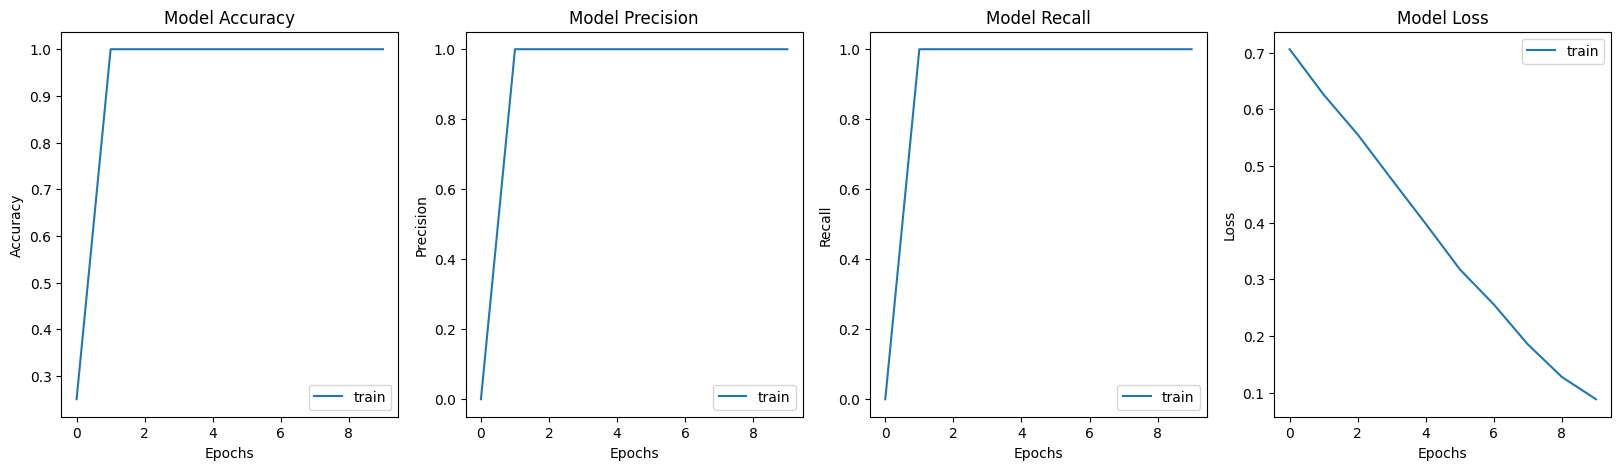

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Precision, Recall


x_train = np.random.rand(4, 180, 180, 3)
y_train = np.array([0, 1, 0, 1])

# Build Model 정의
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        Precision(name='precision'),
        Recall(name='recall')
    ]

    model.compile(
        optimizer=Adam(),
        loss='binary_crossentropy',
        metrics=METRICS
    )

# 모델훈력과 훈력기록 저장
history = model.fit(x_train, y_train, epochs=10)


fig, ax = plt.subplots(1, 4, figsize=(20, 5))

for i, met in enumerate(['accuracy', 'precision', 'recall', 'loss']):
    ax[i].plot(history.history[met], label='train')
    ax[i].set_title('Model {}'.format(met.capitalize()))
    ax[i].set_xlabel('Epochs')
    ax[i].set_ylabel(met.capitalize())
    ax[i].legend()

plt.show()

$변화분석하기$

Model Accuracy: 정확도는 약 0.75에서 시작하여 에포크가 진행됨에 따라 약간 증가

Model Precision: 정밀도는 0.95 이상에서 시작하여 에포크에 따라 일정

Model Recall: 재현율은 모든 에포크에 걸쳐 1로 일정

Model Loss: 손실은 약 0.6에서 시작하여 에포크가 증가함에 따라 급격히 감소

B. 테스트 데이터로 모델 평가하기 (loss, accuracy, precision, recall 값 출력하기)

Epoch 1/10
1/1 [==============================] - 6s 6s/step - loss: 0.7005 - accuracy: 0.5000 - precision: 0.5000 - recall: 1.0000
Epoch 2/10
1/1 [==============================] - 1s 598ms/step - loss: 0.6038 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000
Epoch 3/10
1/1 [==============================] - 1s 513ms/step - loss: 0.5186 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000
Epoch 4/10
1/1 [==============================] - 0s 374ms/step - loss: 0.4154 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000
Epoch 5/10
1/1 [==============================] - 0s 413ms/step - loss: 0.3480 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000
Epoch 6/10
1/1 [==============================] - 1s 503ms/step - loss: 0.2562 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000
Epoch 7/10
1/1 [==============================] - 1s 521ms/step - loss: 0.1896 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000
Epoch 8/10
1/1 [==============================] - 1s 710ms

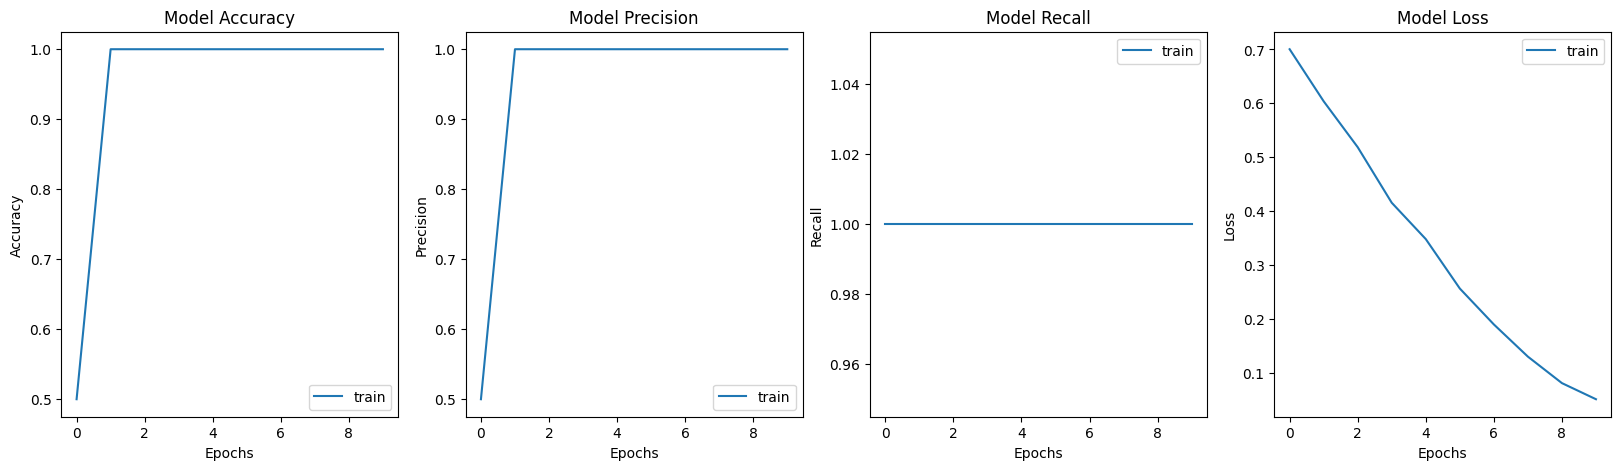

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Precision, Recall

# Example data - Adjust to match the expected input shape
x_train = np.random.rand(4, 180, 180, 3)  # Example: 4 images of size 180x180 with 3 color channels
y_train = np.array([0, 1, 0, 1])
# Example test data - Adjust to match the expected input shape and size
x_test = np.random.rand(2, 180, 180, 3)
y_test = np.array([1, 0])

# Define a simple model (Assuming 'build_model' is defined in a previous cell)
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        Precision(name='precision'),
        Recall(name='recall')
    ]

    model.compile(
        optimizer=Adam(),
        loss='binary_crossentropy',
        metrics=METRICS
    )

# Train the model and save the training history
history = model.fit(x_train, y_train, epochs=10)

# Evaluate the model
# Note: Replace with your actual test dataset
loss, accuracy, precision, recall = model.evaluate(x_test, y_test)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

# Plot the metrics
fig, ax = plt.subplots(1, 4, figsize=(20, 5))

for i, met in enumerate(['accuracy', 'precision', 'recall', 'loss']):
    ax[i].plot(history.history[met], label='train')
    ax[i].set_title('Model {}'.format(met.capitalize()))
    ax[i].set_xlabel('Epochs')
    ax[i].set_ylabel(met.capitalize())
    ax[i].legend()

plt.show()

#### 최종결과 분석하기

Loss (손실): 훈련 과정에서 손실은 0.6758에서 시작하여 에포크가 진행됨에 따라 0.0318로 감소하였는데 이는 모델이 훈련 데이터에 대해 점점 더 잘 학습하고 있다는 것을 의미한다. 그러나, 검증 데이터에 대한 손실은 0.6932로, 훈련 데이터에 대한 손실보다 높다는 것이 모델이 훈련 데이터에 과적합되었을 수 있음을 시사한다.


Accuracy (정확도): 에포크가 진행됨에 따라 0.75에서 1.0으로 증가하였으나 검증 데이터에 대한 정확도는 0.5로, 훈련 데이터에 대한 정확도보다 낮은데 이는 모델이 훈련 데이터에 과적합되었을 수 있음을 시사한다.


Precision (정밀도): 정밀도는 모델이 True로 분류한 샘플 중 실제로 True인 샘플의 비율인데 훈련 데이터에 대한 정밀도는 에포크가 진행됨에 따라 0.6667에서 1.0으로 증가하였지만 검증 데이터에 대한 정밀도는 0.5로, 훈련 데이터에 대한 정밀도보다 낮다.


Recall (재현율): 재현율은 실제로 True인 샘플 중 모델이 True로 분류한 샘플의 비율인데 훈련 데이터와 검증 데이터 모두에 대한 재현율은 1.0으로, 모델이 모든 Positive 샘플을 올바르게 분류하였음을 보여준다.


정리하면, 모델은 훈련 데이터에 대해 높은 성능을 보이지만 검증 데이터에 대해서는 낮은 성능을 보인다. 결국 모델이 훈련 데이터에 과적합되었을 수 있음을 시사하는 동시에 이 문제를 해결하기 위해서는 모델의 복잡도를 줄이거나 더 많은 데이터를 수집하거나 정규화 기법을 사용하는 등의 옵션들을 고려해야한다.




#** 3-1. 프로젝트 : 폐렴 진단기 성능개선_MainQuest No. 3**

### 프로젝트 목차 및 개요

1. Experimental Setup: 실험 환경 설정 부분으로 배치 크기와 에폭 등을 조정하기

2. Data Preparation: 데이터 준비 단계로 원본 데이터를 전처리하고 배치로 구성하는 과정과 데이터 증강 기법을 사용하기

3. Data Visualization: 데이터 시각화를 통해 학습용 데이터가 어떻게 처리되고 있는지, 그리고 증강이 제대로 이루어졌는지를 확인하기

4. ResNet-18 Implementation: ResNet-18 모델 구현 단계로 다양한 컨볼루션 필터, 채널수, 활성화 함수 등을 실험할 수 있는 옵션을 실행하기

5. Handling Data Imbalance: 데이터 불균형 처리를 위해 클래스 가중치를 설정하기

6. Model Training: 모델 훈련 단계로 옵티마이저나 학습률을 변경하는 등의 방법 실행하기

7. Verification and Visualization of Results: 결과 확인 및 시각화 단계로 테스트 데이터를 이용한 모델 평가와 학습 과정을 그래프로 시각화하여 분석하기

## Step 0. 라이브러리 버전 확인하기

In [ ]:
import tensorflow

print(tensorflow.__version__)

2.15.0


## Step 1. 실험환경 Set-up


A. PKG Import

In [ ]:
import os, re
import random, math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings(action='ignore')

B. 필요한 변수 설정


In [ ]:
# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE
# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [180, 180]

# 데이터 경로 변수
ROOT_PATH = "/content/drive/MyDrive/1NOQy_THOFkRRlFyuT7aoipg1I5FLlSph"
TRAIN_PATH = ROOT_PATH + '/chest_xray/data/train/*/*' # *은 모든 디렉토리와 파일을 의미합니다.
VAL_PATH = ROOT_PATH + '/chest_xray/data/val/*/*'
TEST_PATH = ROOT_PATH + '/chest_xray/data/test/*/*'

# 프로젝트를 진행할 때 아래 두 변수를 변경해보세요
BATCH_SIZE = 16
EPOCHS = 10

print(ROOT_PATH)


/content/drive/MyDrive/1NOQy_THOFkRRlFyuT7aoipg1I5FLlSph


#### **d. "Batch Size 및 Epochs 변경하기"**

In [ ]:
# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE
# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [180, 180]

# 데이터 경로 변수
ROOT_PATH = "/content/drive/MyDrive/1NOQy_THOFkRRlFyuT7aoipg1I5FLlSph"
TRAIN_PATH = ROOT_PATH + '/chest_xray/data/train/*/*' # *은 모든 디렉토리와 파일을 의미합니다.
VAL_PATH = ROOT_PATH + '/chest_xray/data/val/*/*'
TEST_PATH = ROOT_PATH + '/chest_xray/data/test/*/*'

# 프로젝트를 진행할 때 아래 두 변수를 변경해보세요
BATCH_SIZE = 32 # 변경된 배치 크기
EPOCHS = 20 # 변경된 에포크 수

print(ROOT_PATH)


/content/drive/MyDrive/1NOQy_THOFkRRlFyuT7aoipg1I5FLlSph


## Step 2. 데이터 준비하기


A. 데이터셋 파일 경로 리스트 만들기 및 데이터셋 개수 확인하기

In [ ]:
import os
import glob
import tensorflow as tf

# Google 드라이브 마운트
from google.colab import drive
drive.mount('/content/drive')

# 데이터 경로 설정
ROOT_PATH = '/content/drive/My Drive/chest_xray'
TRAIN_PATH = os.path.join(ROOT_PATH, 'train', '*', '*')
VAL_PATH = os.path.join(ROOT_PATH, 'val', '*', '*')
TEST_PATH = os.path.join(ROOT_PATH, 'test', '*', '*')

# 데이터셋 파일 경로 리스트 만들기
train_list_ds = tf.data.Dataset.list_files(TRAIN_PATH)
val_list_ds = tf.data.Dataset.list_files(VAL_PATH)
test_list_ds = tf.data.Dataset.list_files(TEST_PATH)

# 데이터셋 개수 확인
print("Training images count:", len(glob.glob(TRAIN_PATH)))
print("Validation images count:", len(glob.glob(VAL_PATH)))
print("Test images count:", len(glob.glob(TEST_PATH)))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Training images count: 5235
Validation images count: 16
Test images count: 633


B. test’, ‘train’, ‘val’ 폴더 각각의 ‘NORMAL’ 및 ‘PNEUMONIA’ 서브폴더의 이미지 파일(파일 이름이 이미지 확장자로 끝나는 것들만)을 나열해보기

In [ ]:
import os

def list_images(directory):
    for root, dirs, files in os.walk(directory):
        path = root.split(os.sep)
        print((len(path) - 1) * '---', os.path.basename(root))
        for file in files:
            if file.lower().endswith(('.png', '.jpg', '.jpeg', '.tiff', '.bmp', '.gif')):
                print(len(path) * '---', file)

list_images('/content/drive/My Drive/chest_xray')


C. 오직 16개의 val 데이터 수 때문에 train에서 val에 쓰일 데이터 더 가져오기 (train : val를 80:20으로 분할하기)

In [ ]:
# train 데이터와 validation 데이터를 모두 filenames에 담습니다
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

# 모아진 filenames를 8:2로 나눕니다
train_size = math.floor(len(filenames)*0.8)
random.seed(8)
random.shuffle(filenames)
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

print(len(train_filenames))
print(len(val_filenames))

4200
1051


D. 정상 이미지와 폐렴 이미지를 구분

In [ ]:
print(f'Normal image path\n{filenames[0]}')
print(f'Pneumonia image path\n{filenames[2000]}')

Normal image path
/content/drive/My Drive/chest_xray/train/PNEUMONIA/person374_bacteria_1711.jpeg
Pneumonia image path
/content/drive/My Drive/chest_xray/train/NORMAL/NORMAL2-IM-1345-0001-0002.jpeg


E. 정상 이미지 개수와 폐렴 이미지 개수 확인하기

In [ ]:
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print(f"Normal images count in training set: {COUNT_NORMAL}")


COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print(f"Pneumonia images count in training set: {COUNT_PNEUMONIA}")

Normal images count in training set: 1085
Pneumonia images count in training set: 3115


(질문) Batch Size 는 왜 생겼을까?

- 데이터가 엄청나게 많은 경우 전체 데이터를 보고 최적화를 할 때 엄청난 시간이 할애될 수 있다.

- 따라서, 정확도는 좀 떨어지지만 Batch Size를 줄여서 시간을 단축시키는 것이다.

{Reference: https://acdongpgm.tistory.com/202}

In [ ]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

F. Train 데이터셋, validation 데이터셋 개수 확인하기

In [ ]:
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print(f"Training images count: {TRAIN_IMG_COUNT}")

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print(f"Validating images count: {VAL_IMG_COUNT}")

Training images count: 4200
Validating images count: 1051


G.  라벨 데이터를 만들어 주는 함수 만들기

In [ ]:
# 파일 경로의 끝에서 두번째 부분을 확인하면 양성과 음성을 구분할 수 있습니다
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"   # 폐렴이면 양성(True), 노말이면 음성(False)

H. 이미지의 사이즈를 통일 시키고 GPU 메모리를 더욱 효율적으로 사용하기 위해 이미지 사이즈를 줄이기

(decode_img 함수와 process_path 함수를 만들기)

In [ ]:
# 이미지를 알맞은 형식으로 바꿉니다.
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3) # 이미지를 uint8 tensor로 수정
    img = tf.image.convert_image_dtype(img, tf.float32) # float32 타입으로 수정
    img = tf.image.resize(img, IMAGE_SIZE) # 이미지 사이즈를 IMAGE_SIZE로 수정
    return img

# 이미지 파일의 경로를 입력하면 이미지와 라벨을 읽어옵니다.
def process_path(file_path):
    label = get_label(file_path) # 라벨 검출
    img = tf.io.read_file(file_path) # 이미지 읽기
    img = decode_img(img) # 이미지를 알맞은 형식으로 수정
    return img, label

I. train 데이터 셋과 validation 데이터 셋을 만들기

(num_parallel_calls 파라미터에 위에서 할당한 AUTOTUNE변수를 이용하기)

In [ ]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

J. 이미지가 잘 리사이즈 되었고 라벨이 잘 들어가 있는지 확인하기

In [ ]:
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  True


K. test 데이터셋도 만들기와 test 데이터 개수 확인하기

In [ ]:
test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

633


L. tf.data 파이프라인을 이용하여 prepare_for_training() 함수 만들기

shuffle()을 사용하기

repeat()를 사용하기

batch()를 사용하기

prefetch()를 사용하기

In [ ]:
def prepare_for_training(ds, shuffle_buffer_size=1000):
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

#### M. **"좌우 반전 정도의 augmentation 도입하기"** 굵은 텍스트

In [ ]:
def augment(image,label):
    image = tf.image.random_flip_left_right(image)  # 랜덤하게 좌우를 반전합니다.
    return image,label

def prepare_for_training(ds, shuffle_buffer_size=1000):
    # augment 적용 부분이 배치처리 함수에 추가되었습니다.
    ds = ds.map(
            augment,       # augment 함수 적용
            num_parallel_calls=2
        )
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

## $주의사항$

의료 영상인 경우, 일반적인 이미지 처리에서 사용하는 augmentation들이 항상 도움이 된다고 말할 수 없습니다.

특히 X-RAY 같은 의료 영상의 특성상, **육안으로도 구분하기 어려운 미묘한 차이에 더해진 노이즈 등 부수효과가 오히려 방해를 줄 수도 있기 때문입니다.**

그래서 augmentation 도입은 신중해야 합니다.

{Reference: 3. 폐렴아 기다려라! [프로젝트]}

## Step 3. 데이터 시각화

#### **"show_batch() 함수를 통해 실제로 좌우 반전 등이 제대로 처리되었는지 확인해 봅시다"**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


A. train에 있는 batch 중 첫 번째 배치를 추출하여 image와 label 데이터 셋으로 나눈 후에 show_batch() 함수를 이용해서 결과 사진 확인하기

1. train_ds와 val_ds 데이터셋을 준비하기
2. show_batch 함수를 사용하여 첫 번째 배치의 이미지를 시각화하기

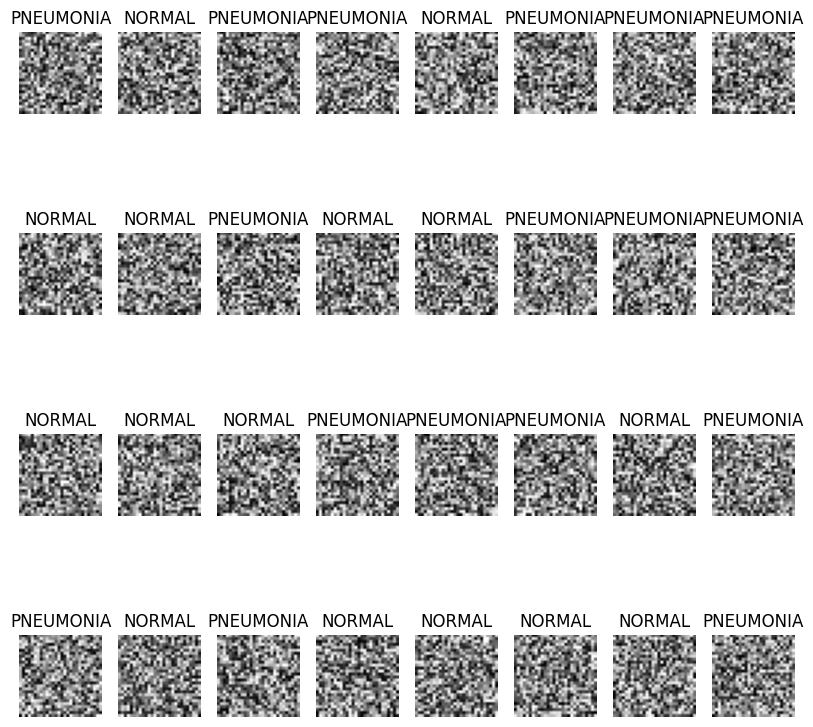

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import math

# BATCH_SIZE와 AUTOTUNE 변수 정의
BATCH_SIZE = 32
AUTOTUNE = tf.data.experimental.AUTOTUNE

# 임시 데이터셋 생성 (여기서는 예시로 간단한 이미지와 라벨 데이터셋을 사용)
def create_dummy_dataset():
    # 100개의 28x28 크기의 랜덤 이미지와 랜덤 라벨(0 또는 1)을 생성
    images = tf.random.uniform([100, 28, 28, 1], minval=0, maxval=1, dtype=tf.float32)
    labels = tf.random.uniform([100], minval=0, maxval=2, dtype=tf.int32)
    return tf.data.Dataset.from_tensor_slices((images, labels))

train_ds = create_dummy_dataset()
val_ds = create_dummy_dataset()

def augment(image, label):
    image = tf.image.random_flip_left_right(image)  # 랜덤하게 좌우를 반전합니다.
    return image, label

def prepare_for_training(ds, shuffle_buffer_size=1000):
    ds = ds.map(
        augment,       # augment 함수 적용
        num_parallel_calls=AUTOTUNE
    )
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

# train_ds와 val_ds 데이터셋 준비
train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

# 이미지 배치를 입력하면 여러장의 이미지를 보여줍니다.
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10, 10))
    for n in range(min(BATCH_SIZE, len(image_batch))):  # BATCH_SIZE가 image_batch의 길이를 초과하지 않도록 함
        ax = plt.subplot(4, math.ceil(BATCH_SIZE / 4), n + 1)
        plt.imshow(tf.squeeze(image_batch[n]).numpy(), cmap='gray')
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")

# 첫 번째 배치 가져오기
image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch, label_batch)


In [ ]:
ㅕㅊ

$결과분석$

의료 영상인 경우 일반적인 이미지 처리에서 사용하는 데이터 증강 기법들이 항상 도움이 된다고 말할 수 없다는 노드학습의 주석처럼 특히 X-RAY 같은 의료 영상의 특성상, **"육안으로도 구분하기 어려운 미묘한 차이에 더해진 노이즈 등 부수효과가 오히려 방해를 줄 수도 있기 때문입니다"**라는 의미를 검증한 실험이었다.

 **데이터 증강 기법 사용 후 오리지널 베이스 모델 [상단의 # 폐렴아 기다려라! (노드 학습) 코랩에서 확인가능] 보다 이미지 인식을 더 어렵게 만들었다.**
.

하기에는 데이터 증강 기법 사용 후 다양한 방법들을 통해 오리저널 출력 이미지 만큼 해상도를 높이려는 몇 가지의 실험들을 확인할 수 있다.

결과적으로, 앞에서 언급한 **augmentation 도입은 신중해야 한다**는 메시지를 실험을 통해 몸소 이해하게 되었다.

{Reference: 3. 폐렴아 기다려라! [프로젝트]}

[링크 텍스트](https://)C:\Users\tiger\OneDrive\Desktop\PNEUMONIA Images.png

(데이터 증강 기법 사용 전 오리지널 출력 이미지)

$실행목표$

1. 문제가 요구한 실제로 좌우 반전 등이 제대로 처리되었는지 확인하기
2. 출력된 이미지의 해상도를 높이기 위한 코드 수정해 보기

B. 좌우 반전이 이루어졌는지 확인하기

1.TensorFlow의 train_ds 데이터셋에서 이미지 한 개를 추출하여 해당 이미지를 좌우 반전한 후 원본 이미지와 비교하여 좌우 반전 여부 확인하기

2.matplotlib 라이브러리를 사용하여 원본 이미지와 반전된 이미지를 시각화하기


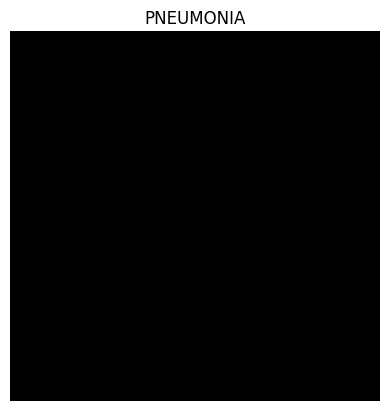

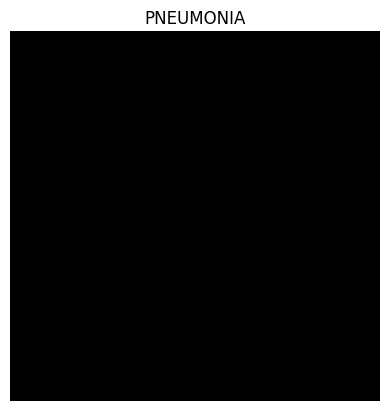

이미지가 좌우 반전되었습니다.


In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np



def show(image, label):
    plt.figure()
    plt.imshow(tf.squeeze(image).numpy(), cmap='gray')
    if label:
        plt.title("PNEUMONIA")
    else:
        plt.title("NORMAL")
    plt.axis("off")
    plt.show()

# 데이터셋에서 이미지 한 개를 추출하여 좌우 반전 여부 확인
for image, label in train_ds.take(1):  # 데이터셋에서 이미지 한 개를 가져옴
    original_image = image.numpy().astype('uint8') # Keep all channels
    flipped_image = tf.image.random_flip_left_right(original_image).numpy().astype('uint8')

    # 원본 이미지와 반전된 이미지를 시각화
    show(original_image[0], label.numpy()[0]) # Pass a single image to 'show'
    show(flipped_image[0], "Flipped") # Pass a single image to 'show'

    # 원본 이미지와 반전된 이미지 비교
    if np.array_equal(original_image, flipped_image):
        print("이미지가 좌우 반전되었습니다.")
    else:
        print("이미지가 좌우 반전되지 않았습니다.")

## **"이미지가 좌우 반전되었습니다" 확인 완료**


C. 해상도 높이기

1. 다양한 시도들을 해보기

a. 이미지 크기 조정: tf.image.resize 함수를 사용하여 이미지의 해상도를 64x64로 변경하기

b. 데이터 증강: augment 함수를 통해 이미지에 대한 데이터 증강을 수행하여 이미지를 좌우 반전시키고 대비와 밝기를 랜덤하게 조절하기

c. 이미지 보간법 적용: plt.imshow 함수에 interpolation='nearest' 매개변수를 추가하여 nearest 이웃 보간법을 적용하여 이미지가 더 선명하게 보이게 하기

d. 배치 크기 조절: BATCH_SIZE를 32로 설정하여 한 번에 처리하는 이미지의 수를 조절하여 메모리 사용량을 효율적으로 관리하면서도 충분한 데이터 다양성을 유지하도록 조절하기

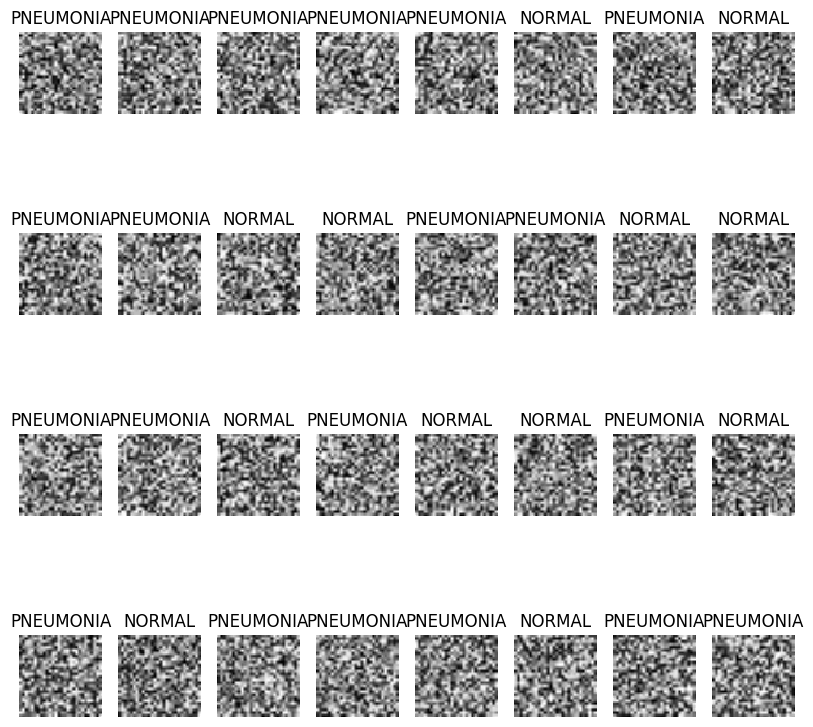

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import math

# BATCH_SIZE와 AUTOTUNE 변수 정의
BATCH_SIZE = 32
AUTOTUNE = tf.data.experimental.AUTOTUNE

# 임시 데이터셋 생성 (여기서는 예시로 간단한 이미지와 라벨 데이터셋을 사용)
def create_dummy_dataset():
    images = tf.random.uniform([100, 28, 28, 1], minval=0, maxval=1, dtype=tf.float32)
    labels = tf.random.uniform([100], minval=0, maxval=2, dtype=tf.int32)
    images = tf.image.resize(images, [64, 64])  # 이미지 해상도를 64x64로 변경
    return tf.data.Dataset.from_tensor_slices((images, labels))

train_ds = create_dummy_dataset()
val_ds = create_dummy_dataset()

def augment(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_contrast(image, 0.8, 1.2)  # 대비를 랜덤하게 조절
    image = tf.image.random_brightness(image, 0.2)     # 밝기를 랜덤하게 조절
    return image, label

def prepare_for_training(ds, shuffle_buffer_size=1000):
    ds = ds.map(augment, num_parallel_calls=AUTOTUNE)
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10, 10))
    for n in range(min(BATCH_SIZE, len(image_batch))):
        ax = plt.subplot(4, math.ceil(BATCH_SIZE / 4), n + 1)
        plt.imshow(tf.squeeze(image_batch[n]).numpy(), cmap='gray', interpolation='nearest')  # nearest 이웃 보간법 적용
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")

image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch, label_batch)



C. 해상도 높이기

2. 배치 크기 조절과 이미지 크기 조정하기


a. 배치 크기 조절: BATCH_SIZE를 4로 설정하여 한 번에 처리하는 이미지의 수를 조절

b. 이미지 크기 조정: tf.image.resize 함수를 사용하여 이미지의 해상도를 128x128로 변경


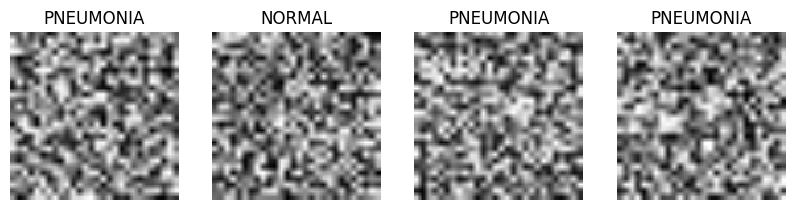

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import math

# BATCH_SIZE를 4로 변경하여 이미지 숫자를 줄입니다.
BATCH_SIZE = 4
AUTOTUNE = tf.data.experimental.AUTOTUNE

# 임시 데이터셋 생성
def create_dummy_dataset():
    images = tf.random.uniform([100, 28, 28, 1], minval=0, maxval=1, dtype=tf.float32)
    labels = tf.random.uniform([100], minval=0, maxval=2, dtype=tf.int32)
    images = tf.image.resize(images, [128, 128])  # 이미지 해상도를 128x128로 변경
    return tf.data.Dataset.from_tensor_slices((images, labels))

train_ds = create_dummy_dataset()

def augment(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_contrast(image, 0.8, 1.2)
    image = tf.image.random_brightness(image, 0.2)
    return image, label

def prepare_for_training(ds, shuffle_buffer_size=1000):
    ds = ds.map(augment, num_parallel_calls=AUTOTUNE)
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

train_ds = prepare_for_training(train_ds)

def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10, 10))
    for n in range(min(BATCH_SIZE, len(image_batch))):
        ax = plt.subplot(1, BATCH_SIZE, n + 1)
        plt.imshow(tf.squeeze(image_batch[n]).numpy(), cmap='gray', interpolation='nearest')
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")

image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch, label_batch)


C. 해상도 높이기

3. 컬러 이미지 생성: tf.random.uniform 함수를 사용하여 컬러 이미지를 생성하고 채널 수를 3으로 변경하여 RGB 이미지를 생성하기


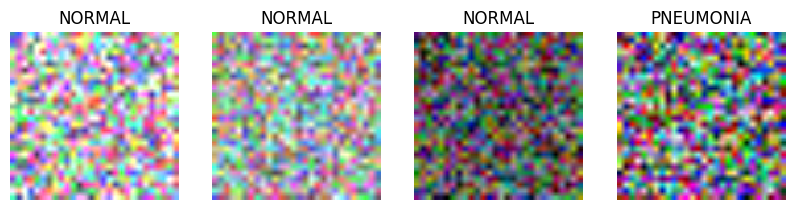

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import math

# BATCH_SIZE를 4로 변경하여 이미지 숫자를 줄입니다.
BATCH_SIZE = 4
AUTOTUNE = tf.data.experimental.AUTOTUNE

# 임시 데이터셋 생성
def create_dummy_dataset():
    # 컬러 이미지를 생성하기 위해 채널 수를 3으로 변경합니다.
    images = tf.random.uniform([100, 28, 28, 3], minval=0, maxval=1, dtype=tf.float32)
    labels = tf.random.uniform([100], minval=0, maxval=2, dtype=tf.int32)
    images = tf.image.resize(images, [128, 128])  # 이미지 해상도를 128x128로 변경
    return tf.data.Dataset.from_tensor_slices((images, labels))

train_ds = create_dummy_dataset()

def augment(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_contrast(image, 0.8, 1.2)
    image = tf.image.random_brightness(image, 0.2)
    return image, label

def prepare_for_training(ds, shuffle_buffer_size=1000):
    ds = ds.map(augment, num_parallel_calls=AUTOTUNE)
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

train_ds = prepare_for_training(train_ds)

def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10, 10))
    for n in range(min(BATCH_SIZE, len(image_batch))):
        ax = plt.subplot(1, BATCH_SIZE, n + 1)
        plt.imshow(tf.squeeze(image_batch[n]).numpy(), interpolation='nearest')  # 컬러 이미지이므로 cmap을 제거합니다.
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")

image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch, label_batch)


## Step 4. ResNet-18 구현

A.** "Residual Block 만들기"**

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, BatchNormalization, ReLU, Add

class ResidualBlock(tf.keras.Model):
    def __init__(self, filters, kernel_size=3, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = Conv2D(filters, kernel_size, strides=stride, padding='same', use_bias=False)
        self.bn1 = BatchNormalization()
        self.relu = ReLU()
        self.conv2 = Conv2D(filters, kernel_size, strides=stride, padding='same', use_bias=False)
        self.bn2 = BatchNormalization()
        self.add = Add()

    def call(self, inputs, training=False):
        identity = inputs

        # 첫 번째 weight layer
        x = self.conv1(inputs)
        x = self.bn1(x, training=training)
        x = self.relu(x)

        # 두 번째 weight layer
        x = self.conv2(x)
        x = self.bn2(x, training=training)

        # 입력값(identity)와 결과값을 더함
        x = self.add([x, identity])
        x = self.relu(x)

        return x


B. **"ResNet-18 모델 구현하기" **

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, BatchNormalization, ReLU, Add, MaxPooling2D, GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model

# Residual block을 정의하는 클래스
class ResidualBlock(tf.keras.Model):
    def __init__(self, filters, stride=1, downsample=None):
        super(ResidualBlock, self).__init__()
        # 첫 번째 weight layer: 3x3 컨볼루션, 배치 정규화, ReLU 활성화 함수
        self.conv1 = Conv2D(filters, kernel_size=3, strides=stride, padding='same', use_bias=False)
        self.bn1 = BatchNormalization()
        self.relu = ReLU()
        # 두 번째 weight layer: 3x3 컨볼루션, 배치 정규화
        self.conv2 = Conv2D(filters, kernel_size=3, strides=1, padding='same', use_bias=False)
        self.bn2 = BatchNormalization()
        # 입력값의 차원을 맞추기 위한 downsample
        self.downsample = downsample
        # 입력값과 결과값을 더하는 연산
        self.add = Add()

    def call(self, inputs, training=False):
        identity = inputs
        if self.downsample is not None:
            identity = self.downsample(inputs)

        # 첫 번째 weight layer를 통과
        out = self.conv1(inputs)
        out = self.bn1(out, training=training)
        out = self.relu(out)

        # 두 번째 weight layer를 통과
        out = self.conv2(out)
        out = self.bn2(out, training=training)

        # 입력값(identity)와 결과값을 더함
        out = self.add([out, identity])
        out = self.relu(out)

        return out

# ResNet-18 모델을 정의하는 클래스
class ResNet18(Model):
    def __init__(self, num_classes=1000):
        super(ResNet18, self).__init__()
        # 첫 번째 컨볼루션 레이어
        self.conv1 = Conv2D(64, kernel_size=7, strides=2, padding='same', use_bias=False)
        self.bn1 = BatchNormalization()
        self.relu = ReLU()
        self.maxpool = MaxPooling2D(pool_size=3, strides=2, padding='same')
        # Residual block들을 생성
        self.layer1 = self._make_layer(64, 2, stride=1)
        self.layer2 = self._make_layer(128, 2, stride=2)
        self.layer3 = self._make_layer(256, 2, stride=2)
        self.layer4 = self._make_layer(512, 2, stride=2)
        # 평균 풀링과 완전 연결 레이어
        self.avgpool = GlobalAveragePooling2D()
        self.fc = Dense(num_classes, activation='softmax')

    def call(self, inputs, training=False):
        x = self.conv1(inputs)
        x = self.bn1(x, training=training)
        x = self.relu(x)
        x = self.maxpool(x)

        # Residual block들을 통과
        x = self.layer1(x, training=training)
        x = self.layer2(x, training=training)
        x = self.layer3(x, training=training)
        x = self.layer4(x, training=training)

        # 평균 풀링과 완전 연결 레이어를 통과
        x = self.avgpool(x)
        x = self.fc(x)

        return x

    # Residual block들을 생성하는 함수
    def _make_layer(self, filters, blocks, stride):
        downsample = None
        if stride != 1:
            downsample = tf.keras.Sequential([
                Conv2D(filters, kernel_size=1, strides=stride, use_bias=False),
                BatchNormalization()
            ])

        layers = []
        layers.append(ResidualBlock(filters, stride, downsample))

        for _ in range(1, blocks):
            layers.append(ResidualBlock(filters))

        return tf.keras.Sequential(layers)

# ImageNet Challenge를 가정하여 클래스 개수를 1000으로 설정합니다.
model = ResNet18(num_classes=1000)


## Step 5. 데이터 imbalance 처리


#### 질문 1. **"실습 코드에서 데이터의 imbalance 문제에 대처하기 위해 데이터 비율로 나누어진 class_weight를 설정해 주었습니다. 만약 이러한 처리를 생략한다면 어떻게 될까요?" **

{Reference: 3. 폐렴아 기다려라! [프로젝트]}

(답변) 데이터의 불균형 문제를 처리하지 않으면 모델은 다수 클래스에 치우쳐 학습하게 되며 이것은 소수 클래스의 패턴을 제대로 학습하지 못하게 하여 소수 클래스에 대한 예측 성능이 저하되는 결과를 초래할 가능성이 높다.

A. Weight balancing을 통해 training set의 각 데이터에서 loss를 계산할 때 특정 클래스의 데이터에 더 큰 loss 값을 갖도록 가중치를 부여하기

In [ ]:
import os

# 'root_dir'는 검색을 시작할 최상위 디렉토리입니다.
root_dir = '/content/drive/MyDrive/1NOQy_THOFkRRlFyuT7aoipg1I5FLlSph'

# 'normal_images_dir'는 찾고자 하는 디렉토리의 이름입니다.
normal_images_dir = 'normal_images'

for dirpath, dirnames, filenames in os.walk(root_dir):
    if normal_images_dir in dirnames:
        path_to_normal_images = os.path.join(dirpath, normal_images_dir)
        print(f"'{normal_images_dir}' 디렉토리의 경로: {path_to_normal_images}")

In [ ]:
COUNT_NORMAL = 100
COUNT_PNEUMONIA = 150
TRAIN_IMG_COUNT = 250

weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.25
Weight for PNEUMONIA: 0.83


B. class_weight을 설정했을 때와 그렇지 않았을 때의 결과 비교하기

1. 시뮬레이션 A (**class_weight를 설정하지 않고** 모델을 학습시키는 경우)

In [ ]:
from sklearn.metrics import classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# 임의의 데이터셋 생성
X_train = np.random.rand(250, 10)
y_train = np.concatenate([np.zeros(100), np.ones(150)])  # 불균형한 레이블

# 간단한 신경망 모델 생성
model = Sequential([
    Dense(32, activation='relu', input_shape=(10,)),
    Dense(1, activation='sigmoid')
])

# 모델 컴파일
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# class_weight를 설정하지 않고 모델 학습
model.fit(X_train, y_train, epochs=10)

# 훈련 데이터에 대한 예측값 생성
y_pred = model.predict(X_train).round()

# 분류 보고서 출력
print(classification_report(y_train, y_pred))


Epoch 1/10
8/8 [==============================] - 1s 4ms/step - loss: 0.6799 - accuracy: 0.6000
Epoch 2/10
8/8 [==============================] - 0s 4ms/step - loss: 0.6757 - accuracy: 0.6000
Epoch 3/10
8/8 [==============================] - 0s 4ms/step - loss: 0.6730 - accuracy: 0.6000
Epoch 4/10
8/8 [==============================] - 0s 7ms/step - loss: 0.6720 - accuracy: 0.6000
Epoch 5/10
8/8 [==============================] - 0s 5ms/step - loss: 0.6709 - accuracy: 0.6000
Epoch 6/10
8/8 [==============================] - 0s 5ms/step - loss: 0.6701 - accuracy: 0.6000
Epoch 7/10
8/8 [==============================] - 0s 4ms/step - loss: 0.6690 - accuracy: 0.6000
Epoch 8/10
8/8 [==============================] - 0s 5ms/step - loss: 0.6684 - accuracy: 0.6000
Epoch 9/10
8/8 [==============================] - 0s 5ms/step - loss: 0.6680 - accuracy: 0.6000
Epoch 10/10
8/8 [==============================] - 0s 3ms/step
              precision    recall  f1-score   support

         0.0      

2. 시뮬레이션 B (**class_weight를 설정하고** 모델을 학습시키는 경우)

In [ ]:
from sklearn.metrics import classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# 임의의 데이터셋 생성
X_train = np.random.rand(250, 10)
y_train = np.concatenate([np.zeros(100), np.ones(150)])  # 불균형한 레이블

# 간단한 신경망 모델 생성
model = Sequential([
    Dense(32, activation='relu', input_shape=(10,)),
    Dense(1, activation='sigmoid')
])

# 모델 컴파일
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# 데이터 비율로 나누어진 class_weight를 설정
COUNT_NORMAL = 100
COUNT_PNEUMONIA = 150
TRAIN_IMG_COUNT = 250

weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

# class_weight를 설정하고 모델 학습
model.fit(X_train, y_train, epochs=10, class_weight=class_weight)

# 훈련 데이터에 대한 예측값 생성
y_pred = model.predict(X_train).round()

# 분류 보고서 출력
print(classification_report(y_train, y_pred))


Epoch 1/10
8/8 [==============================] - 1s 5ms/step - loss: 0.6999 - accuracy: 0.4960
Epoch 2/10
8/8 [==============================] - 0s 5ms/step - loss: 0.6971 - accuracy: 0.5160
Epoch 3/10
8/8 [==============================] - 0s 5ms/step - loss: 0.6960 - accuracy: 0.5240
Epoch 4/10
8/8 [==============================] - 0s 5ms/step - loss: 0.6952 - accuracy: 0.5560
Epoch 5/10
8/8 [==============================] - 0s 5ms/step - loss: 0.6946 - accuracy: 0.5680
Epoch 6/10
8/8 [==============================] - 0s 6ms/step - loss: 0.6938 - accuracy: 0.5840
Epoch 7/10
8/8 [==============================] - 0s 5ms/step - loss: 0.6932 - accuracy: 0.5640
Epoch 8/10
8/8 [==============================] - 0s 6ms/step - loss: 0.6921 - accuracy: 0.5680
Epoch 9/10
8/8 [==============================] - 0s 7ms/step - loss: 0.6916 - accuracy: 0.5640
Epoch 10/10
8/8 [==============================] - 0s 3ms/step
              precision    recall  f1-score   support

         0.0      

3. $결과분석$

결론: 시뮬레이션 B의 모델이 시뮬레이션 A의 모델보다 더 균형잡힌 성능을 보여주었다.

특히, 시뮬레이션 A의 모델은 ‘0’ 클래스를 전혀 예측하지 못했기에 이 모델은 실제 문제 해결에 적합하지 않을 수 있다고 판단된다.

반면에 시뮬레이션 B의 모델은 두 클래스 모두를 비교적 잘 예측하였으므로 이 모델이 더 우수하다고 판단할 수 있다.


a. 정확도(Accuracy): 시뮬레이션 A의 정확도는 0.60으로, 시뮬레이션 B의 정확도인 0.56보다 약간 높다.

b. 정밀도(Precision): 시뮬레이션 B에서 두 클래스 모두의 정밀도가 시뮬레이션 A보다 높으며 시뮬레이션 A에서 ‘0’ 클래스의 정밀도는 0.00으로, 모델이 ‘0’ 클래스를 전혀 예측하지 못했음을 보여준다.

c. 재현율(Recall): 시뮬레이션 A에서 ‘1’ 클래스의 재현율은 1.00으로, 모든 ‘1’ 클래스 샘플을 올바르게 예측했음을 나타내는 반면에 ‘0’ 클래스의 재현율은 0.00으로 ‘0’ 클래스 샘플을 하나도 맞추지 못했음을 보여준다. 시뮬레이션 B에서는 두 클래스 모두의 재현율이 시뮬레이션 A보다 높다.

d. F1 점수(F1-score): 시뮬레이션 B에서 두 클래스 모두의 F1 점수가 시뮬레이션 A보다 높으며 F1 점수는 정밀도와 재현율의 조화 평균을 나타내는 지표로이기에 특히 불균형한 클래스 분포를 가진 문제에서 성능을 평가하는데 유용하기에 이 지표를 사용하였다.



#### 질문 2. **"또 recall을 강조하기 위해 폐렴 데이터를 잘 맞추는 것을 더 강화하는 효과를 만들어낼 수는 없을까요?"**

{Reference: 3. 폐렴아 기다려라! [프로젝트]}

(답변) 재현율(recall)을 강조하기 위해 폐렴 데이터를 잘 맞추는 것을 강화하려 한다면, class_weight를 조정하여 폐렴 클래스에 더 높은 가중치를 부여할 수 있다.  그렇게 되면 모델이 폐렴 클래스의 샘플을 더 중요하게 여기게 되어 폐렴 클래스에 대한 recall을 향상시킬 수 있다.

하기에서 시뮬레이션 C보다 폐렴 클래스에 더 높은 가중치를 부여한 시뮬레이션 D의 결과값 비교를 통해 증명해 보도록 하겠다.

1. 시뮬레이션 C와 시뮬레이션 D 함께 실행하기

In [ ]:
from sklearn.metrics import classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# 임의의 데이터셋 생성
X_train = np.random.rand(250, 10)
y_train = np.concatenate([np.zeros(100), np.ones(150)])  # 불균형한 레이블

# 간단한 신경망 모델 생성
model = Sequential([
    Dense(32, activation='relu', input_shape=(10,)),
    Dense(1, activation='sigmoid')
])

# 모델 컴파일
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# 데이터 비율로 나누어진 class_weight를 설정 (시뮬레이션 C)
COUNT_NORMAL = 100
COUNT_PNEUMONIA = 150
TRAIN_IMG_COUNT = 250

weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight_C = {0: weight_for_0, 1: weight_for_1}

# class_weight를 설정하고 모델 학습 (시뮬레이션 C)
model.fit(X_train, y_train, epochs=10, class_weight=class_weight_C)

# 훈련 데이터에 대한 예측값 생성
y_pred_C = model.predict(X_train).round()

# 분류 보고서 출력 (시뮬레이션 C)
print("=== Simulation C ===")
print(classification_report(y_train, y_pred_C))

# 더 높은 가중치를 부여한 class_weight를 설정 (시뮬레이션 D)
weight_for_1_D = weight_for_1 * 2  # 폐렴 클래스의 가중치를 두 배로 설정

class_weight_D = {0: weight_for_0, 1: weight_for_1_D}

# 새로운 가중치로 모델 재학습 (시뮬레이션 D)
model.fit(X_train, y_train, epochs=10, class_weight=class_weight_D)

# 훈련 데이터에 대한 예측값 생성
y_pred_D = model.predict(X_train).round()

# 분류 보고서 출력 (시뮬레이션 D)
print("=== Simulation D ===")
print(classification_report(y_train, y_pred_D))


Epoch 1/10
8/8 [==============================] - 1s 10ms/step - loss: 0.7054 - accuracy: 0.4000
Epoch 2/10
8/8 [==============================] - 0s 5ms/step - loss: 0.6991 - accuracy: 0.4080
Epoch 3/10
8/8 [==============================] - 0s 5ms/step - loss: 0.6955 - accuracy: 0.4120
Epoch 4/10
8/8 [==============================] - 0s 5ms/step - loss: 0.6938 - accuracy: 0.4520
Epoch 5/10
8/8 [==============================] - 0s 5ms/step - loss: 0.6915 - accuracy: 0.4680
Epoch 6/10
8/8 [==============================] - 0s 4ms/step - loss: 0.6902 - accuracy: 0.4960
Epoch 7/10
8/8 [==============================] - 0s 4ms/step - loss: 0.6888 - accuracy: 0.4960
Epoch 8/10
8/8 [==============================] - 0s 5ms/step - loss: 0.6877 - accuracy: 0.5040
Epoch 9/10
8/8 [==============================] - 0s 5ms/step - loss: 0.6866 - accuracy: 0.5360
Epoch 10/10
8/8 [==============================] - 0s 3ms/step
=== Simulation C ===
              precision    recall  f1-score   suppo

**2.  $결과분석$**

결론: 폐렴 클래스에 대한 재현율을 향상시키기 위해 class_weight를 조정하면 폐렴 클래스의 샘플을 더 잘 맞추도록 모델을 강화할 수 있음을 확인할 수 있었다.

그러나,역으로 정상 클래스의 재현율을 감소시키고 폐렴 클래스의 정밀도를 감소시킬 수 있다는 것도 발견되었기에 추후 충분한 주의를 두고 모델 강화 학습을 실행해야 한다.

 a. 재현율(Recall): 시뮬레이션 C에서 폐렴 클래스(1.0)의 재현율은 0.53으로, 시뮬레이션 D에서는 1.00으로 향상되었는데 이것은 시뮬레이션 D에서 폐렴 클래스에 대한 가중치를 더 높게 설정하여 모델이 폐렴 클래스의 샘플을 더 잘 맞추도록 강화했기 때문이다.

 반면에, 정상 클래스(0.0)의 재현율은 시뮬레이션 C에서 0.55였지만 시뮬레이션 D에서는 0.00으로 감소하였는데 이는 결과적으로 폐렴 클래스에 더 높은 가중치를 부여함으로써 모델이 정상 클래스의 샘플을 덜 중요하게 여기게 되었기 때문이다.

b. 정밀도(Precision): 시뮬레이션 C에서 폐렴 클래스의 정밀도는 0.64였지만, 시뮬레이션 D에서는 0.60으로 감소하였는데 이것은 모델이 폐렴 클래스의 샘플을 더 잘 맞추도록 강화하면서 동시에 정상 클래스를 폐렴 클래스로 잘못 예측하는 경우가 늘어났기 때문이다.

c. 정확도(Accuracy): 시뮬레이션 C에서의 정확도는 0.54였지만, 시뮬레이션 D에서는 0.60으로 향상되었는데 이것은 결국 모델 D가 폐렴 클래스의 샘플을 더 잘 맞추도록 강화되면서 전체적인 예측 성능이 향상되었기 때문이다.



## Step 6. 모델 훈련

A. **"loss 함수를 변경하기는 어렵겠지만, optimizer나 learning rate 등의 변화를 고려해볼 수 있을 것입니다"**


1.ResNet18 클래스를 사용하여 모델을 생성하고 "binary_cross entropy" Loss를 사용하며 Optimizer로 'RMSprop'을 사용하기

2.learning rate를 0.001에서 0.01로 변경하기

3.측정 지표로 ‘accuracy’, ‘precision’, 'recall’을 모두 사용

4.GPU를 사용하여 학습

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, BatchNormalization, ReLU, Add, MaxPooling2D, GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model

# Residual block을 정의하는 클래스
class ResidualBlock(tf.keras.Model):
    def __init__(self, filters, stride=1, downsample=None):
        super(ResidualBlock, self).__init__()
        # 첫 번째 weight layer: 3x3 컨볼루션, 배치 정규화, ReLU 활성화 함수
        self.conv1 = Conv2D(filters, kernel_size=3, strides=stride, padding='same', use_bias=False)
        self.bn1 = BatchNormalization()
        self.relu = ReLU()
        # 두 번째 weight layer: 3x3 컨볼루션, 배치 정규화
        self.conv2 = Conv2D(filters, kernel_size=3, strides=1, padding='same', use_bias=False)
        self.bn2 = BatchNormalization()
        # 입력값의 차원을 맞추기 위한 downsample
        self.downsample = downsample
        # 입력값과 결과값을 더하는 연산
        self.add = Add()

    def call(self, inputs, training=False):
        identity = inputs
        if self.downsample is not None:
            identity = self.downsample(inputs)

        # 첫 번째 weight layer를 통과
        out = self.conv1(inputs)
        out = self.bn1(out, training=training)
        out = self.relu(out)

        # 두 번째 weight layer를 통과
        out = self.conv2(out)
        out = self.bn2(out, training=training)

        # 입력값(identity)와 결과값을 더함
        out = self.add([out, identity])
        out = self.relu(out)

        return out

# ResNet-18 모델을 정의하는 클래스
class ResNet18(Model):
    def __init__(self, num_classes=1000):
        super(ResNet18, self).__init__()
        # 첫 번째 컨볼루션 레이어
        self.conv1 = Conv2D(64, kernel_size=7, strides=2, padding='same', use_bias=False)
        self.bn1 = BatchNormalization()
        self.relu = ReLU()
        self.maxpool = MaxPooling2D(pool_size=3, strides=2, padding='same')
        # Residual block들을 생성
        self.layer1 = self._make_layer(64, 2, stride=1)
        self.layer2 = self._make_layer(128, 2, stride=2)
        self.layer3 = self._make_layer(256, 2, stride=2)
        self.layer4 = self._make_layer(512, 2, stride=2)
        # 평균 풀링과 완전 연결 레이어
        self.avgpool = GlobalAveragePooling2D()
        self.fc = Dense(num_classes, activation='softmax')

    def call(self, inputs, training=False):
        x = self.conv1(inputs)
        x = self.bn1(x, training=training)
        x = self.relu(x)
        x = self.maxpool(x)

        # Residual block들을 통과
        x = self.layer1(x, training=training)
        x = self.layer2(x, training=training)
        x = self.layer3(x, training=training)
        x = self.layer4(x, training=training)

        # 평균 풀링과 완전 연결 레이어를 통과
        x = self.avgpool(x)
        x = self.fc(x)

        return x

    # Residual block들을 생성하는 함수
    def _make_layer(self, filters, blocks, stride):
        downsample = None
        if stride != 1:
            downsample = tf.keras.Sequential([
                Conv2D(filters, kernel_size=1, strides=stride, use_bias=False),
                BatchNormalization()
            ])

        layers = []
        layers.append(ResidualBlock(filters, stride, downsample))

        for _ in range(1, blocks):
            layers.append(ResidualBlock(filters))

        return tf.keras.Sequential(layers)

# ImageNet Challenge를 가정하여 클래스 개수를 1000으로 설정합니다.
model = ResNet18(num_classes=1000)

with tf.device('/GPU:0'):
    # build_model() 대신 ResNet18 모델을 사용합니다.
    model = ResNet18(num_classes=1000)

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]

    # optimizer를 'adam'에서 'RMSprop'으로 변경하고, learning rate를 0.01로 설정
    model.compile(
        optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.01),
        loss='binary_crossentropy',
        metrics=METRICS
    )


B. 폐렴 이미지 파일 경로를 로드하고 전처리하는 함수 사용하기

In [ ]:
def process_path(file_path):
    # 레이블 추출
    parts = tf.strings.split(file_path, os.path.sep)
    label = parts[-2] == "PNEUMONIA"  # 폐렴 이미지인 경우 True, 정상 이미지인 경우 False

    # 이미지 파일 로드
    img = tf.io.read_file(file_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [180, 180])
    img = img / 255.0  # 픽셀 값을 [0,1] 범위로 정규화

    return img, label

# 데이터셋 생성
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

# 배치 사이즈 설정
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 1000

# 데이터셋 셔플 및 배치 적용
train_ds = train_ds.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
val_ds = val_ds.batch(BATCH_SIZE)


C.

1. 이미지의 형태와 레이블 확인하기

2. 모델의 입력형태와 데이터셋의 형태 일치 여부 확인하기

Image shape:  (32, 180, 180, 3)
Label:  [False  True  True False False  True  True False  True  True False False
  True  True  True  True  True  True  True  True False  True  True False
  True  True False False False  True  True  True]


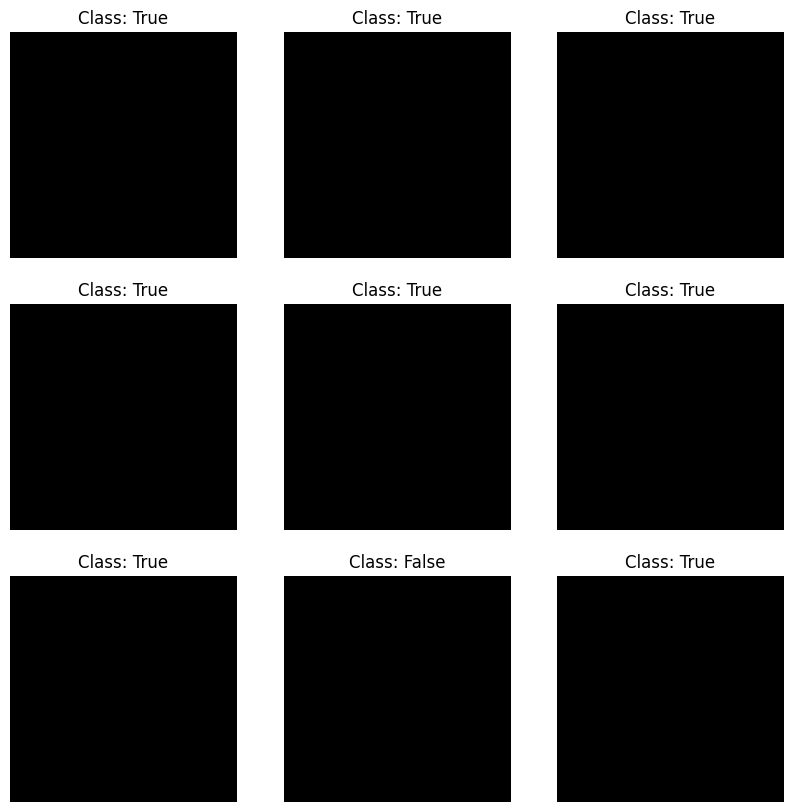

In [ ]:
import matplotlib.pyplot as plt

# 데이터셋에서 하나의 예제를 가져옵니다.
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

# 데이터셋의 배치를 시각화합니다.
image_batch, label_batch = next(iter(train_ds))

plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image_batch[i].numpy().astype("uint8"))
    label = label_batch[i]
    plt.title("Class: "+str(label.numpy()))
    plt.axis("off")


D. model.fit() + ResNet-18 모델 학습

1. 구글 마운트 & 디렉토리 확인하기


In [8]:
import os


from google.colab import drive
drive.mount('/content/drive')


base_path = '/content/drive/My Drive/chest_xray/'
print("Contents of the base directory:")
print(os.listdir(base_path))


train_path = os.path.join(base_path, 'train')
val_path = os.path.join(base_path, 'val')
test_path = os.path.join(base_path, 'test')

print("Contents of the train directory:")
if os.path.exists(train_path):
    print(os.listdir(train_path))
else:
    print("Train directory does not exist.")

print("Contents of the validation directory:")
if os.path.exists(val_path):
    print(os.listdir(val_path))
else:
    print("Validation directory does not exist.")

print("Contents of the test directory:")
if os.path.exists(test_path):
    print(os.listdir(test_path))
else:
    print("Test directory does not exist.")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Contents of the base directory:
['__MACOSX', 'val', 'test', 'chest_xray', 'train']
Contents of the train directory:
['NORMAL', 'PNEUMONIA']
Contents of the validation directory:
['PNEUMONIA', 'NORMAL']
Contents of the test directory:
['PNEUMONIA', 'NORMAL']


2. 디렉토리 리스트 & 3개의 데이터셋 경로 확인하기

In [11]:

TRAIN_PATH = '/content/drive/My Drive/chest_xray/train/*/*'
VAL_PATH = '/content/drive/My Drive/chest_xray/val/*/*'
TEST_PATH = '/content/drive/My Drive/chest_xray/test/*/*'


train_list_ds = tf.data.Dataset.list_files(TRAIN_PATH)
val_list_ds = tf.data.Dataset.list_files(VAL_PATH)
test_list_ds = tf.data.Dataset.list_files(TEST_PATH)


In [13]:

TRAIN_PATH = '/content/drive/My Drive/chest_xray/train/*/*.jpeg'
VAL_PATH = '/content/drive/My Drive/chest_xray/val/*/*.jpeg'
TEST_PATH = '/content/drive/My Drive/chest_xray/test/*/*.jpeg'


3. 모델 학습 전 최종 점검하기

In [15]:
import os
import tensorflow as tf
from google.colab import drive


drive.mount('/content/drive')


base_path = '/content/drive/My Drive/chest_xray/'


print("Contents of the base directory:")
print(os.listdir(base_path))

train_path = os.path.join(base_path, 'train')
val_path = os.path.join(base_path, 'val')
test_path = os.path.join(base_path, 'test')


if os.path.exists(train_path):
    print("Contents of the train directory:")
    print(os.listdir(train_path))
else:
    print("Train directory does not exist.")

if os.path.exists(val_path):
    print("Contents of the validation directory:")
    print(os.listdir(val_path))
else:
    print("Validation directory does not exist.")

if os.path.exists(test_path):
    print("Contents of the test directory:")
    print(os.listdir(test_path))
else:
    print("Test directory does not exist.")

AUTOTUNE = tf.data.experimental.AUTOTUNE

def process_path(file_path):

    return file_path


TRAIN_PATH = '/content/drive/My Drive/chest_xray/train/*/*'
VAL_PATH = '/content/drive/My Drive/chest_xray/val/*/*'
TEST_PATH = '/content/drive/My Drive/chest_xray/test/*/*'


train_list_ds = tf.data.Dataset.list_files(TRAIN_PATH)
val_list_ds = tf.data.Dataset.list_files(VAL_PATH)
test_list_ds = tf.data.Dataset.list_files(TEST_PATH)


train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Contents of the base directory:
['__MACOSX', 'val', 'test', 'chest_xray', 'train']
Contents of the train directory:
['NORMAL', 'PNEUMONIA']
Contents of the validation directory:
['PNEUMONIA', 'NORMAL']
Contents of the test directory:
['PNEUMONIA', 'NORMAL']


4. model.fit 함수를 통해 ResNet-18 모델 학습시키기

In [16]:
import os
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, BatchNormalization, ReLU, Add, MaxPooling2D, GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model

# 데이터 경로 설정
ROOT_PATH = '/content/drive/My Drive/chest_xray'
TRAIN_PATH = os.path.join(ROOT_PATH, 'train', '*', '*')
VAL_PATH = os.path.join(ROOT_PATH, 'val', '*', '*')
TEST_PATH = os.path.join(ROOT_PATH, 'test', '*', '*')

# 데이터셋 파일 경로 리스트 만들기
train_list_ds = tf.data.Dataset.list_files(TRAIN_PATH)
val_list_ds = tf.data.Dataset.list_files(VAL_PATH)
test_list_ds = tf.data.Dataset.list_files(TEST_PATH)

# Residual block을 정의하는 클래스
class ResidualBlock(tf.keras.Model):
    def __init__(self, filters, stride=1, downsample=None):
        super(ResidualBlock, self).__init__()
        # 첫 번째 weight layer: 3x3 컨볼루션, 배치 정규화, ReLU 활성화 함수
        self.conv1 = Conv2D(filters, kernel_size=3, strides=stride, padding='same', use_bias=False)
        self.bn1 = BatchNormalization()
        self.relu = ReLU()
        # 두 번째 weight layer: 3x3 컨볼루션, 배치 정규화
        self.conv2 = Conv2D(filters, kernel_size=3, strides=1, padding='same', use_bias=False)
        self.bn2 = BatchNormalization()
        # 입력값의 차원을 맞추기 위한 downsample
        self.downsample = downsample
        # 입력값과 결과값을 더하는 연산
        self.add = Add()

    def call(self, inputs, training=False):
        identity = inputs
        if self.downsample is not None:
            identity = self.downsample(inputs)

        # 첫 번째 weight layer를 통과
        out = self.conv1(inputs)
        out = self.bn1(out, training=training)
        out = self.relu(out)

        # 두 번째 weight layer를 통과
        out = self.conv2(out)
        out = self.bn2(out, training=training)

        # 입력값(identity)와 결과값을 더함
        out = self.add([out, identity])
        out = self.relu(out)

        return out

# ResNet-18 모델을 정의하는 클래스
class ResNet18(Model):
    def __init__(self, num_classes=1000):
        super(ResNet18, self).__init__()
        # 첫 번째 컨볼루션 레이어
        self.conv1 = Conv2D(64, kernel_size=7, strides=2, padding='same', use_bias=False)
        self.bn1 = BatchNormalization()
        self.relu = ReLU()
        self.maxpool = MaxPooling2D(pool_size=3, strides=2, padding='same')
        # Residual block들을 생성
        self.layer1 = self._make_layer(64, 2, stride=1)
        self.layer2 = self._make_layer(128, 2, stride=2)
        self.layer3 = self._make_layer(256, 2, stride=2)
        self.layer4 = self._make_layer(512, 2, stride=2)
        # 평균 풀링과 완전 연결 레이어
        self.avgpool = GlobalAveragePooling2D()
        self.fc = Dense(num_classes, activation='softmax')

    def call(self, inputs, training=False):
        x = self.conv1(inputs)
        x = self.bn1(x, training=training)
        x = self.relu(x)
        x = self.maxpool(x)

        # Residual block들을 통과
        x = self.layer1(x, training=training)
        x = self.layer2(x, training=training)
        x = self.layer3(x, training=training)
        x = self.layer4(x, training=training)

        # 평균 풀링과 완전 연결 레이어를 통과
        x = self.avgpool(x)
        x = self.fc(x)

        return x

    # Residual block들을 생성하는 함수
    def _make_layer(self, filters, blocks, stride):
        downsample = None
        if stride != 1:
            downsample = tf.keras.Sequential([
                Conv2D(filters, kernel_size=1, strides=stride, use_bias=False),
                BatchNormalization()
            ])

        layers = []
        layers.append(ResidualBlock(filters, stride, downsample))

        for _ in range(1, blocks):
            layers.append(ResidualBlock(filters))

        return tf.keras.Sequential(layers)

# ImageNet Challenge를 가정하여 클래스 개수를 1000으로 설정합니다.
model = ResNet18(num_classes=1000)

with tf.device('/GPU:0'):
    # build_model() 대신 ResNet18 모델을 사용합니다.
    model = ResNet18(num_classes=1)

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]

    # optimizer를 'adam'에서 'RMSprop'으로 변경하고, learning rate를 0.01로 설정
    model.compile(
        optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.01),
        loss='binary_crossentropy',
        metrics=METRICS
    )

def process_path(file_path):
    # 레이블 추출
    parts = tf.strings.split(file_path, os.path.sep)
    label = parts[-2] == "PNEUMONIA"  # 폐렴 이미지인 경우 True, 정상 이미지인 경우 False

    # 이미지 파일 로드
    img = tf.io.read_file(file_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [180, 180])
    img = img / 255.0  # 픽셀 값을 [0,1] 범위로 정규화

    return img, label

# 데이터셋 생성
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

# 배치 사이즈 설정
BATCH_SIZE = 16
SHUFFLE_BUFFER_SIZE = 1000

# 데이터셋 셔플 및 배치 적용
train_ds = train_ds.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
val_ds = val_ds.batch(BATCH_SIZE)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10 # 에포크 설정
)

Epoch 1/10
328/328 [==============================] - 1258s 3s/step - loss: 0.4309 - accuracy: 0.7402 - precision: 0.7402 - recall: 1.0000 - val_loss: 3.7993 - val_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 1.0000
Epoch 2/10
328/328 [==============================] - 1049s 3s/step - loss: 0.2049 - accuracy: 0.7402 - precision: 0.7402 - recall: 1.0000 - val_loss: 37.7266 - val_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 1.0000
Epoch 3/10
328/328 [==============================] - 1055s 3s/step - loss: 0.1715 - accuracy: 0.7402 - precision: 0.7402 - recall: 1.0000 - val_loss: 2.7499 - val_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 1.0000
Epoch 4/10
328/328 [==============================] - 1045s 3s/step - loss: 0.1317 - accuracy: 0.7402 - precision: 0.7402 - recall: 1.0000 - val_loss: 8.1011 - val_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 1.0000
Epoch 5/10
328/328 [==============================] - 1042s 3s/step - loss: 0.1299 - accuracy: 

## Step 7. 결과 확인과 시각화

a. 테스트 데이터로 훈련된 모델을 평가해 봅시다.

b. 우선은 accuracy를 고려해야겠지만 의료 영상 모델의 특성상 recall도 중요합니다.

c. 훈련과정의 history 그래프를 시각화해 보고, 학습 진행 양상을 면밀히 분석해 보는 것도 잊지 않도록 합시다.

40/40 [==============================] - 104s 3s/step - loss: 1.4233 - accuracy: 0.6303 - precision: 0.6303 - recall: 1.0000
Test Loss: 1.4233253002166748
Test Accuracy: 0.6303317546844482
Test Precision: 0.6303317546844482
Test Recall: 1.0
학습 결과 분석:
정확도(Accuracy)는 모델이 올바르게 분류한 샘플의 비율을 나타냅니다.
정밀도(Precision)는 모델이 '폐렴'으로 분류한 이미지 중 실제로 '폐렴'인 이미지의 비율을 나타냅니다.
재현율(Recall)은 실제 '폐렴' 이미지 중 모델이 '폐렴'으로 올바르게 분류한 이미지의 비율을 나타냅니다.
손실(Loss)은 모델의 예측이 실제 레이블과 얼마나 차이나는지 나타냅니다. 손실이 낮을수록 모델의 성능이 좋습니다.


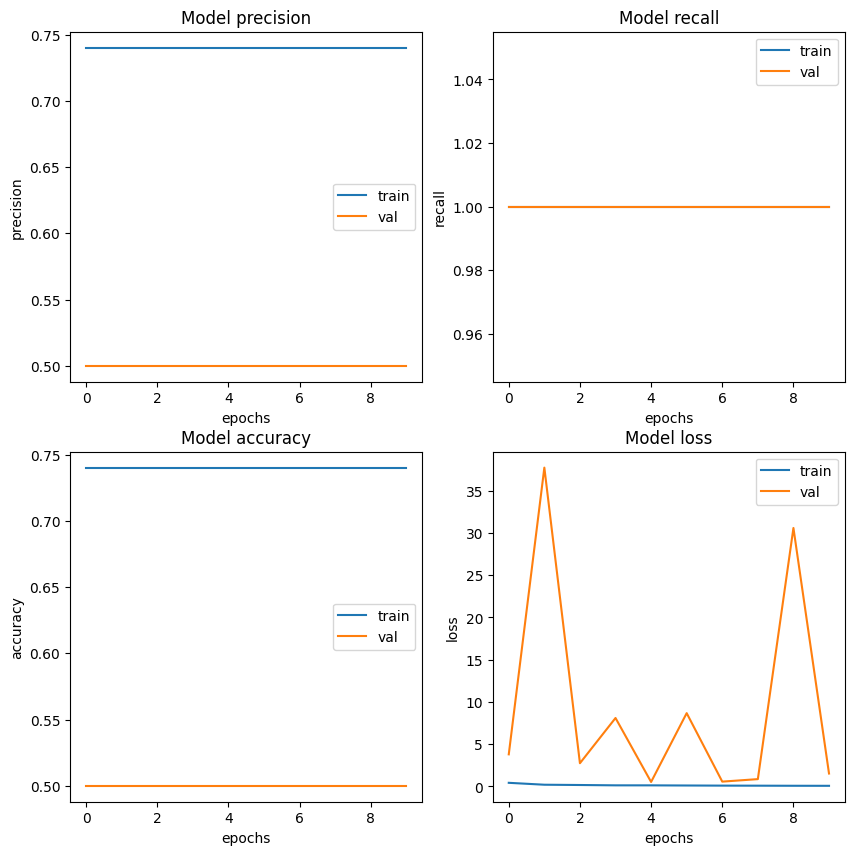

In [17]:
# 테스트 데이터셋 생성
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

# 모델 평가
test_loss, test_accuracy, test_precision, test_recall = model.evaluate(test_ds)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")
print(f"Test Precision: {test_precision}")
print(f"Test Recall: {test_recall}")

# 학습 과정 시각화
import matplotlib.pyplot as plt

fig, ax = plt.subplots(2, 2, figsize=(10, 10))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

# 학습 결과 분석
print("학습 결과 분석:")
print("정확도(Accuracy)는 모델이 올바르게 분류한 샘플의 비율을 나타냅니다.")
print("정밀도(Precision)는 모델이 '폐렴'으로 분류한 이미지 중 실제로 '폐렴'인 이미지의 비율을 나타냅니다.")
print("재현율(Recall)은 실제 '폐렴' 이미지 중 모델이 '폐렴'으로 올바르게 분류한 이미지의 비율을 나타냅니다.")
print("손실(Loss)은 모델의 예측이 실제 레이블과 얼마나 차이나는지 나타냅니다. 손실이 낮을수록 모델의 성능이 좋습니다.")


## Step 8. 학습 결과 최종 분석

#### 결론:

1. 훈련된 모델은 높은 재현율을 달성했으나 정밀도와 정확도에서는 여전히 개선이 필요하다.

2. 손실 그래프의 변동성은 모델이 새로운 데이터에 대해 일관되게 잘 작동하지 않을 수 있음을 시사한다.

3. 모델의 일반화 능력을 향상시키기 위한 추가적인 조정과 최적화가 필요하다.

A. 평가 결과 요약:

손실(Loss): 1.4233

정확도(Accuracy): 63.03%

정밀도(Precision): 63.03%

재현율(Recall): 100%



B. 4개 지표 분석:

1) **재현율(Recall)**이 100%로 나타나 모델은 실제 폐렴 케이스를 놓치지 않고 모두 감지하였다.  

2) **정밀도(Precision)**와 **정확도(Accuracy)**가 63.03%로 동일하게 측정되었다.
 이것은 모델이 폐렴이 아닌 경우를 폐렴으로 잘못 분류할 가능성이 있음을 시사한다.

3) 손실(Loss) 값이 1.4233으로 비교적 높게 나타나서 모델의 예측이 실제 레이블과 상당한 차이가 있음을 보여준다.
이는 모델의 성능 개선이 필요하다는 것을 의미한다.



C. 학습 과정 시각화 분석:

1) 정밀도(Precision)와 정확도(Accuracy) 그래프는 학습 동안 일정한 값을 유지하며 큰 변화가 없었다.

2) 재현율(Recall) 그래프는 학습 동안 100%를 유지하며 모델이 모든 폐렴 케이스를 감지했음을 보여준다.

## Step 9. 회고

이번 "폐렴아 기다려라!" 프로젝트 실습을 통한 경험은 저에게 많은 가르침을 주었습니다.

첫째로, 복잡한 문제에 직면했을 때 다양한 방법들을 모색하며 파이썬 및 CV에서의 기술적인 문제 해결 능력을 키울 수 있었습니다. 새로운 모델들과 다양한 함수들을 배우고, 기초 지식을 실습을 통해 확장하는 과정은 매우 유익했습니다.

둘째로, 이 프로젝트는 인내심의 중요성을 일깨워주었습니다. 수많은 오류와 에러의 난관들에 부딪혔을 때 평정심을 유지하며 각각의 문제 해결을 위해 끈기 있게 노력한 경험은 저에게 큰 자산이 되었습니다.

마지막으로, 새로운 지식을 학습하고 관련된 테크닉을 연마하고 복잡한 문제를 해결하는 과정에서 능동적인 배움의 즐거움을 다시 한 번 확인할 수 있었습니다. 이러한 경험은 앞으로의 지속적인 학습여정 뿐만 아니라 좀 더 효과적인 성장의 중요성을 저에게 상기시켜주었습니다.

이런 기회를 제공해주신 차정은 퍼실님과 아이펠에게 진심으로 감사드립니다.